In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.5 MB/s eta 0:00:00


In [237]:
ch1 = 0
ch2 = 1

Extracting EDF parameters from /content/drive/MyDrive/Паркинсонизм/VLKB/VLKB_trem_1Hz_aftAll_30mA.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 159999  =      0.000 ...     4.000 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EMG 1,1_k., EMG 1,2_k.
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 20000.0 Hz
 meas_date: 2024-06-18 15:46:20 UTC
 nchan: 2
 projs: []
 sfreq: 40000.0 Hz
 subject_info: 4 items (dict)
>
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


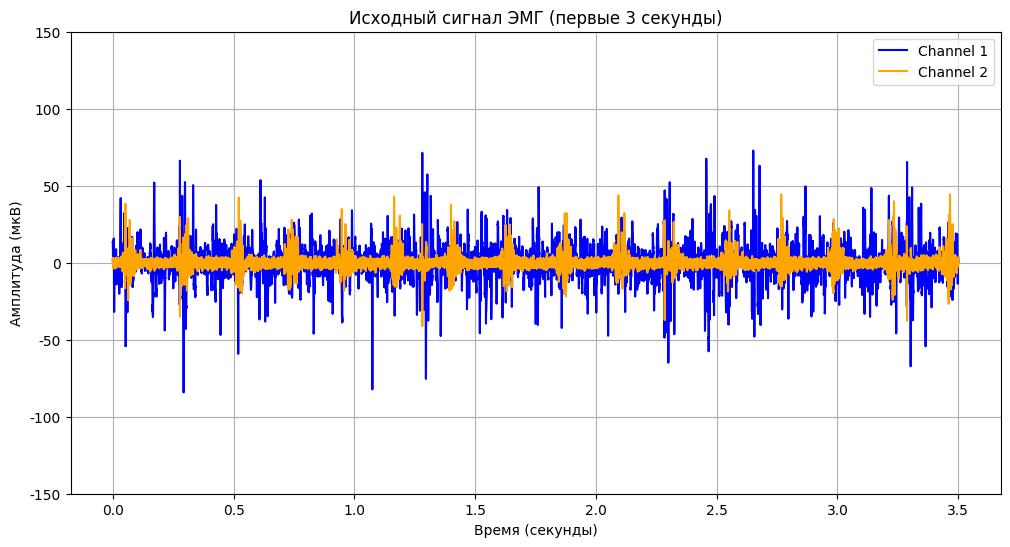

IndexError: arrays used as indices must be of integer (or boolean) type

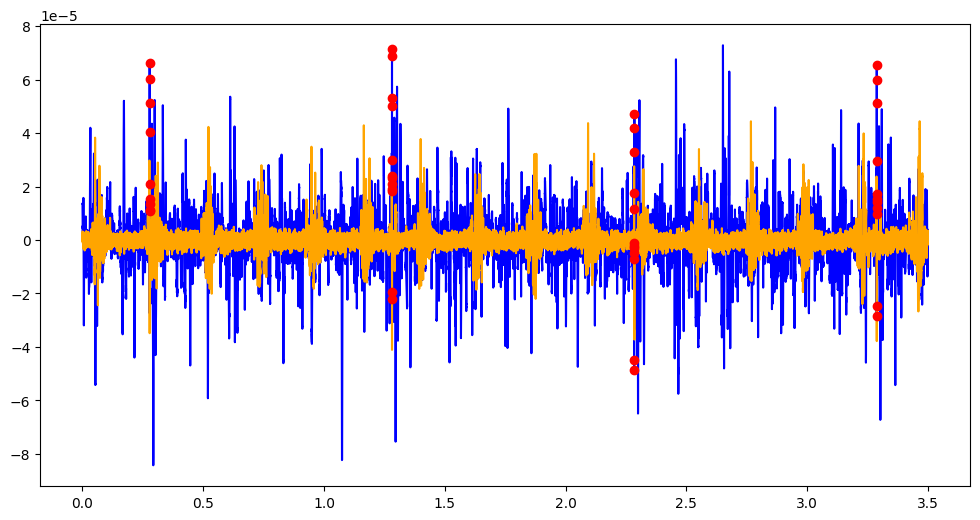

In [239]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# 1. Загрузка EDF+ файла и вывод информации
file_path = '/content/drive/MyDrive/Паркинсонизм/VLKB/VLKB_trem_1Hz_aftAll_30mA.edf'
raw = mne.io.read_raw_edf(file_path, preload=True)
print(raw.info)

# Оставляем только первые два канала
raw.pick_channels([raw.ch_names[ch1], raw.ch_names[ch2]])  # Выбираем первые два канала

# 1.1 Получаем данные первых 3 секунд для анализа
data, times = raw[:2, :]  # Данные для двух каналов на всех временных точках
sampling_rate = raw.info['sfreq']  # Частота дискретизации
time_limit = 3.5  # Ограничение времени до 3 секунд
samples_limit = int(time_limit * sampling_rate)  # Количество выборок для первых 3 секунд

# Ограничим данные 3 секундами
data = data[:, :samples_limit]
times = times[:samples_limit]

# 2. Построение графика исходного сигнала без меток
plt.figure(figsize=(12, 6))

# График для канала 1
plt.plot(times, data[0], label='Channel 1', color='blue')

# График для канала 2
plt.plot(times, data[1], label='Channel 2', color='orange')

# Ограничиваем ось Y диапазоном ±50 мкВ
plt.ylim([-150e-6, 150e-6])

# Оформление графика
plt.title('Исходный сигнал ЭМГ (первые 3 секунды)')
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда (мкВ)')
plt.legend()
plt.grid(True)

# Преобразование шкалы амплитуды в мкВ для удобства
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*1e6:.0f}'))

plt.show()

# 3. Поиск резких скачков амплитуды (на 50+ мкВ за 1-1.5 мс)
threshold = 50e-6  # Порог в 50 мкВ
time_window_ms = 0.2  # Время в миллисекундах для анализа скачков
samples_window = int((time_window_ms / 1000) * sampling_rate)  # Преобразуем в выборки

# Поиск меток по резкому изменению амплитуды
def find_artifact_events(signal, threshold, samples_window):
    artifact_indices = []
    for i in range(len(signal) - samples_window):
        window = signal[i:i + samples_window]  # Окно данных длиной samples_window
        if np.max(window) - np.min(window) > threshold:  # Разница в окне больше порога
            artifact_indices.append(i)  # Запоминаем индекс начала события
    return np.array(artifact_indices)

# Ищем артефакты для обоих каналов
artifact_indices_ch1 = find_artifact_events(data[0], threshold, samples_window)
artifact_indices_ch2 = find_artifact_events(data[1], threshold, samples_window)

# 4. Построение графика первых 3 секунд исходного сигнала с метками
plt.figure(figsize=(12, 6))

# График для канала 1
plt.plot(times, data[0], label='Channel 1', color='blue')
plt.scatter(times[artifact_indices_ch1], data[0][artifact_indices_ch1], color='red', label='Метки артефактов Ch1', zorder=5)

# График для канала 2
plt.plot(times, data[1], label='Channel 2', color='orange')
plt.scatter(times[artifact_indices_ch2], data[1][artifact_indices_ch2], color='green', label='Метки артефактов Ch2', zorder=5)

# Ограничиваем ось Y диапазоном ±50 мкВ
plt.ylim([-150e-6, 150e-6])

# Оформление графика
plt.title('Исходный сигнал ЭМГ с метками артефактов (первые 3 секунды)')
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда (мкВ)')
plt.legend()
plt.grid(True)

# Преобразование шкалы амплитуды в мкВ для удобства
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*1e6:.0f}'))

plt.show()


In [226]:
data[0] * 1e6

array([-9.1636297 , -9.18867932, -9.12605528, ...,  4.843279  ,
        5.22319814,  5.63234182])

In [240]:
# Выбираем только первые значения каждого артефакта
unique_artifact_indices = [artifact_indices_ch1[0]]  # Добавляем первое значение

# Перебираем индексы артефактов и добавляем только те, которые начинаются после предыдущего
for i in range(1, len(artifact_indices_ch1)):
    if artifact_indices_ch1[i] - artifact_indices_ch1[i - 1] > 750:  # Проверяем разницу
        print(artifact_indices_ch1[i] - artifact_indices_ch1[i - 1])
        unique_artifact_indices.append(artifact_indices_ch1[i])

unique_artifact_indices = np.array(unique_artifact_indices)

# Вывод уникальных индексов артефактов
print("Уникальные индексы артефактов:", unique_artifact_indices)

# 2. Вычисляем минимальную длительность промежутков между артефактами
if len(unique_artifact_indices) > 1:
    intervals = np.diff(unique_artifact_indices) / sampling_rate  # Время в секундах
    min_interval_ms = np.min(intervals) * 1000  # Переводим в миллисекунды
else:
    min_interval_ms = None  # Если артефактов не так много

# Выводим минимальную длительность
if min_interval_ms is not None:
    print("Минимальная длительность промежутка между артефактами (мс):", min_interval_ms)
else:
    print("Недостаточно артефактов для расчета промежутков.")

40092
40094
40091
Уникальные индексы артефактов: [ 11112  51212  91347 131480]
Минимальная длительность промежутка между артефактами (мс): 1002.5


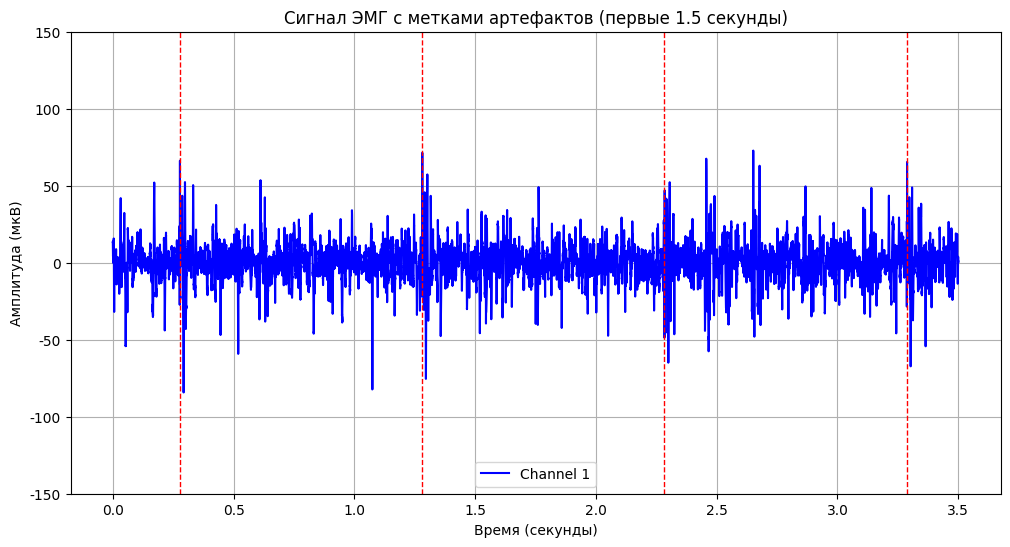

In [241]:
# Определение длительности в секундах
duration_to_plot = 3.5  # Длительность в секундах

# Определяем количество отсчетов для 1.5 секунд
n_samples_to_plot = int(duration_to_plot * raw.info['sfreq'])  # Количество отсчетов для 1.5 секунд

# Ограничиваем временные данные и данные ЭМГ до первых 1.5 секунд
times_to_plot = times[:n_samples_to_plot]  # Время для первых 1.5 секунд
data_to_plot = data[0][:n_samples_to_plot]  # Данные канала 1 для первых 1.5 секунд

# Построение графика первых 1.5 секунд сигнала с метками артефактов
plt.figure(figsize=(12, 6))

# График для канала 1
plt.plot(times_to_plot, data_to_plot, label='Channel 1', color='blue')

# Добавляем вертикальные линии для найденных артефактов
for index in unique_artifact_indices:
    # Переводим индекс в время, если он в пределах первых 1.5 секунд
    if index < n_samples_to_plot:
        time_index = times[index]  # Время, соответствующее индексу
        plt.axvline(x=time_index, color='red', linestyle='--', lw=1)  # Красная линия

# Ограничиваем ось Y диапазоном ±50 мкВ
plt.ylim([-150e-6, 150e-6])

# Оформление графика
plt.title('Сигнал ЭМГ с метками артефактов (первые 1.5 секунды)')
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда (мкВ)')
plt.legend()
plt.grid(True)

# Преобразование шкалы амплитуды в мкВ для удобства
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*1e6:.0f}'))

plt.show()


In [242]:
# Создание событий на основе уникальных индексов артефактов
events = np.array([[index, 0, 1] for index in unique_artifact_indices])  # Формируем события в формате (индекс, 0, 1)

In [243]:
events

array([[ 11112,      0,      1],
       [ 51212,      0,      1],
       [ 91347,      0,      1],
       [131480,      0,      1]])

In [244]:
# Разбиение на эпохи: задаем длительность эпохи и временные параметры
tmin = 0.0   # Начало эпохи за 500 мс до события
tmax = 1  # Конец эпохи в момент события

# Создание объектов Epochs
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, preload=True, baseline=None)

# Отображение информации о созданных эпохах
print(f'Количество эпох: {len(epochs)}')
print(f'Эпохи: {epochs}')

Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 4 events and 40001 original time points ...
1 bad epochs dropped
Количество эпох: 3
Эпохи: <Epochs | 3 events (all good), 0 – 1 s (baseline off), ~1.8 MB, data loaded,
 '1': 3>


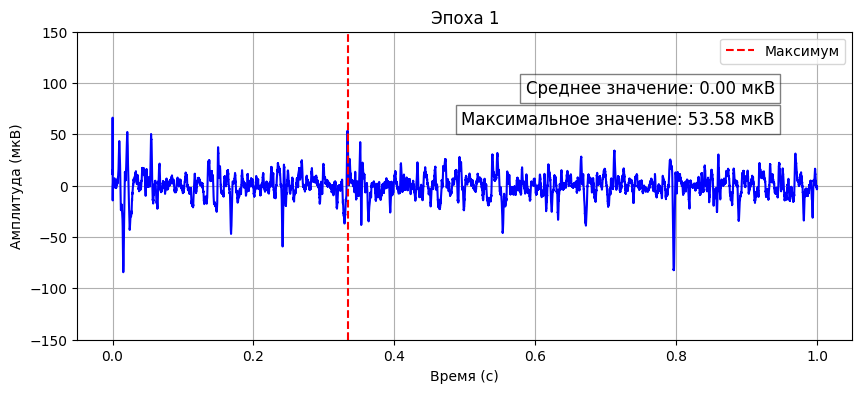

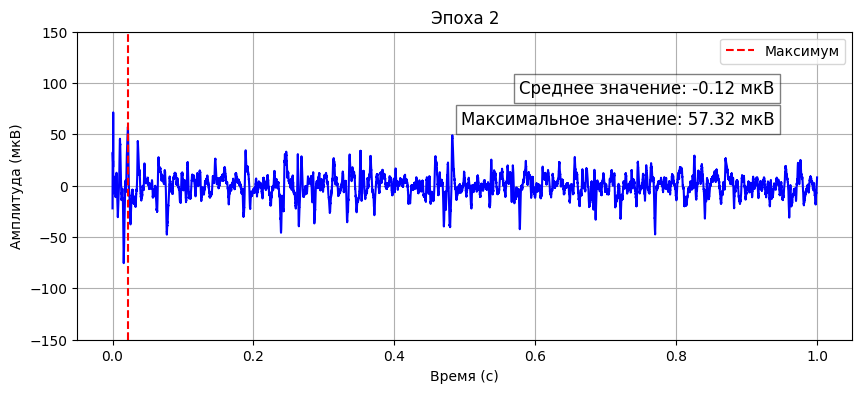

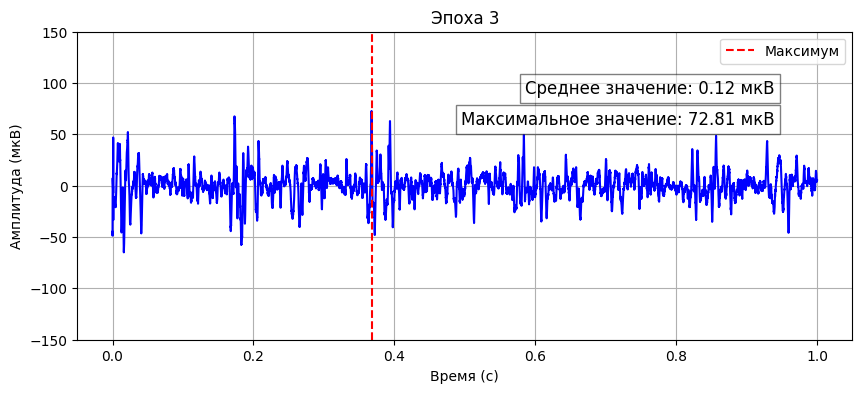

In [245]:
# Визуализация каждой эпохи по отдельности с масштабом -150 до 150 мкВ и подписями среднего и максимального значения амплитуды
for i in range(len(epochs)):
    # Получаем данные для текущей эпохи
    data = epochs[i].get_data(picks=[0]).flatten()  # Получаем данные первого канала и приводим к одной размерности
    times = np.linspace(0, len(data) / epochs.info['sfreq'], num=len(data))  # Создаем временные метки

    # Отрисовка данных
    plt.figure(figsize=(10, 4))  # Устанавливаем размер графика
    plt.plot(times, data * 1e6, color='blue')  # Рисуем данные в мкВ
    plt.title(f'Эпоха {i + 1}')
    plt.ylim(-150, 150)  # Устанавливаем лимиты по оси Y

    # Вычисляем среднее значение амплитуды для этой эпохи
    mean_amplitude = np.mean(data) * 1e6  # Переводим в мкВ

    # Устанавливаем границы для поиска максимального значения
    start_sample = int(0.02 * epochs.info['sfreq'])  # Начинаем с 0.02с
    max_amplitude = np.max(data[start_sample:]) * 1e6  # Максимум с 0.02с до конца
    max_index = start_sample + np.argmax(data[start_sample:])  # Индекс максимального значения

    # Добавляем красную линию в месте максимального значения
    plt.axvline(x=max_index / epochs.info['sfreq'], color='red', linestyle='--', label='Максимум')  # Рисуем вертикальную линию

    # Добавляем текст с средним и максимальным значением амплитуды
    plt.text(0.9, 0.8, f'Среднее значение: {mean_amplitude:.2f} мкВ',
             transform=plt.gca().transAxes, fontsize=12, color='black',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
             ha='right')  # Выровнять текст по правому краю

    plt.text(0.9, 0.7, f'Максимальное значение: {max_amplitude:.2f} мкВ',
             transform=plt.gca().transAxes, fontsize=12, color='black',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
             ha='right')  # Выровнять текст по правому краю

    plt.xlabel('Время (с)')  # Подпись оси X
    plt.ylabel('Амплитуда (мкВ)')  # Подпись оси Y
    plt.legend()  # Показываем легенду
    plt.grid(True)  # Включаем сетку
    plt.show()


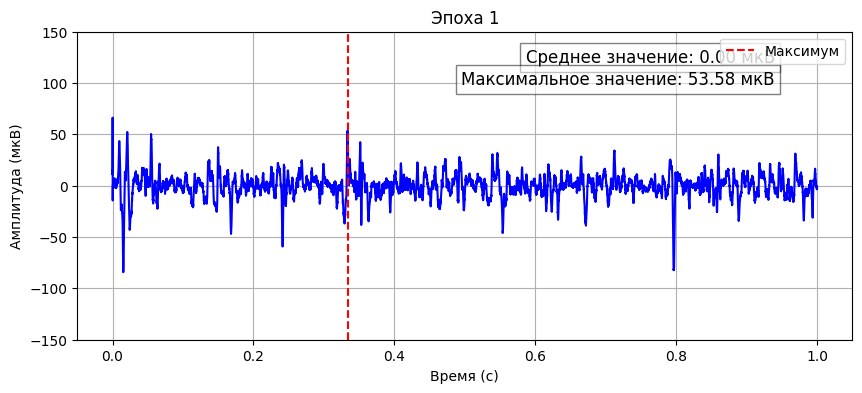

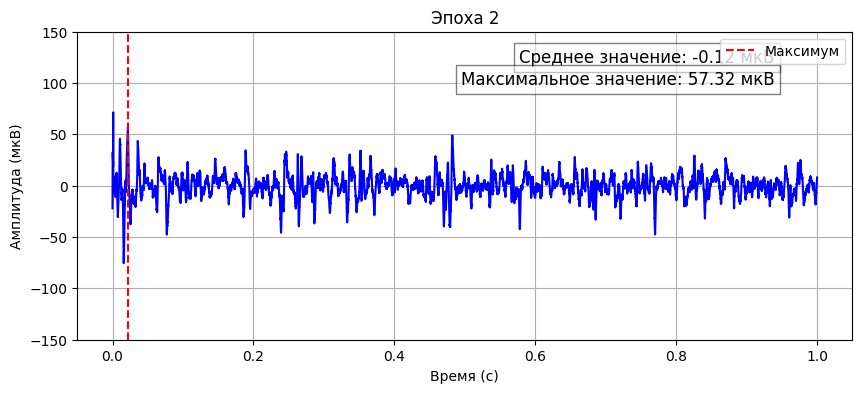

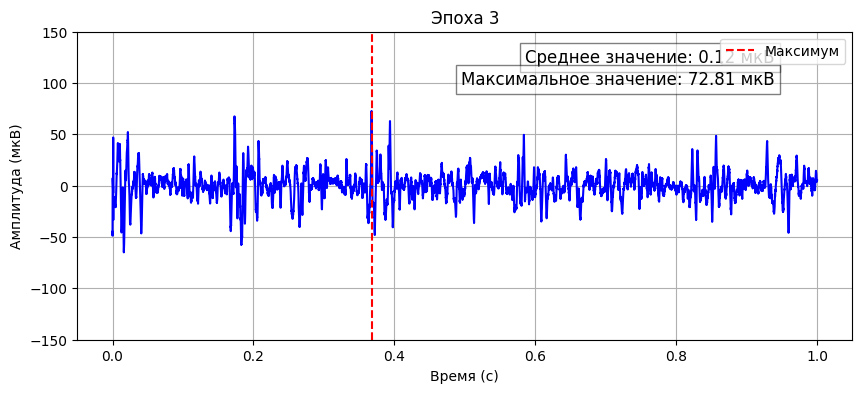

In [246]:
# Список для хранения индексов оставшихся проб
valid_epochs_indices = []

# Фильтруем пробы
for i in range(len(epochs)):
    # Получаем данные для текущей эпохи
    data = epochs[i].get_data(picks=[0]).flatten()  # Получаем данные первого канала и приводим к одной размерности

    # Устанавливаем границы для поиска максимального значения
    start_sample = int(0.02 * epochs.info['sfreq'])  # Начинаем с 0.02с
    max_amplitude = np.max(data[start_sample:]) * 1e6  # Максимум с 0.02с до конца

    # Проверяем, меньше ли максимальное значение 12 мкВ
    if max_amplitude <= 200:
        valid_epochs_indices.append(i)  # Сохраняем индекс проб, которые прошли фильтрацию

# Визуализация оставшихся проб с масштабом -150 до 150 мкВ и подписями среднего и максимального значения амплитуды
for i in valid_epochs_indices:
    # Получаем данные для текущей эпохи
    data = epochs[i].get_data(picks=[0]).flatten()  # Получаем данные первого канала и приводим к одной размерности
    times = np.linspace(0, len(data) / epochs.info['sfreq'], num=len(data))  # Создаем временные метки

    # Отрисовка данных
    plt.figure(figsize=(10, 4))  # Устанавливаем размер графика
    plt.plot(times, data * 1e6, color='blue')  # Рисуем данные в мкВ
    plt.title(f'Эпоха {i + 1}')  # Заголовок
    plt.ylim(-150, 150)  # Устанавливаем лимиты по оси Y

    # Вычисляем среднее значение амплитуды для этой эпохи
    mean_amplitude = np.mean(data) * 1e6  # Переводим в мкВ

    # Устанавливаем границы для поиска максимального значения
    max_amplitude = np.max(data[start_sample:]) * 1e6  # Максимум с 0.02с до конца
    max_index = start_sample + np.argmax(data[start_sample:])  # Индекс максимального значения

    # Добавляем красную линию в месте максимального значения
    plt.axvline(x=max_index / epochs.info['sfreq'], color='red', linestyle='--', label='Максимум')  # Рисуем вертикальную линию

    # Добавляем текст с средним и максимальным значением амплитуды
    plt.text(0.9, 0.9, f'Среднее значение: {mean_amplitude:.2f} мкВ',
             transform=plt.gca().transAxes, fontsize=12, color='black',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
             ha='right')  # Выровнять текст по правому краю

    plt.text(0.9, 0.83, f'Максимальное значение: {max_amplitude:.2f} мкВ',
             transform=plt.gca().transAxes, fontsize=12, color='black',
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
             ha='right')  # Выровнять текст по правому краю

    plt.xlabel('Время (с)')  # Подпись оси X
    plt.ylabel('Амплитуда (мкВ)')  # Подпись оси Y
    plt.legend()  # Показываем легенду
    plt.grid(True)  # Включаем сетку
    plt.show()


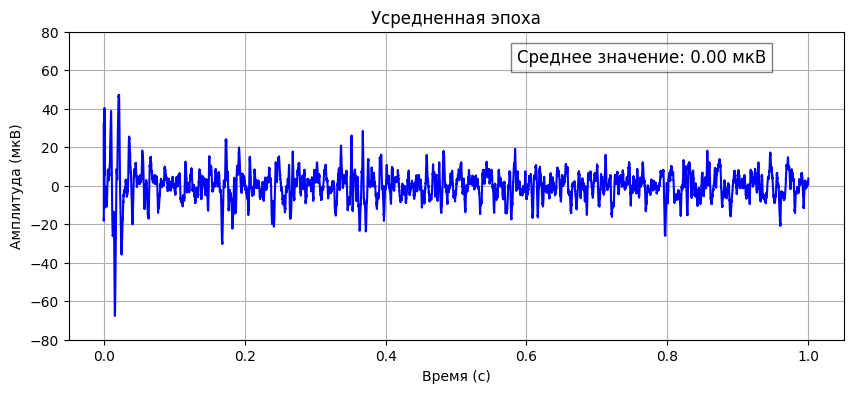

In [247]:
# Получаем данные для всех оставшихся проб
all_data = []
for i in valid_epochs_indices:
    data = epochs[i].get_data(picks=[0]).flatten()  # Получаем данные первого канала и приводим к одной размерности
    all_data.append(data)

# Усредняем оставшиеся эпохи
mean_data = np.mean(all_data, axis=0)  # Усредняем по оставшимся пробам

# Создаем временные метки
times = np.linspace(0, len(mean_data) / epochs.info['sfreq'], num=len(mean_data))

# Отрисовка усредненной эпохи
plt.figure(figsize=(10, 4))  # Устанавливаем размер графика
plt.plot(times, mean_data * 1e6, color='blue')  # Рисуем данные в мкВ
plt.title('Усредненная эпоха')  # Заголовок
plt.ylim(-80, 80)  # Устанавливаем лимиты по оси Y

# Добавляем текст с средним значением амплитуды
mean_amplitude = np.mean(mean_data) * 1e6  # Среднее значение амплитуды в мкВ
plt.text(0.9, 0.9, f'Среднее значение: {mean_amplitude:.2f} мкВ',
         transform=plt.gca().transAxes, fontsize=12, color='black',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
         ha='right')  # Выровнять текст по правому краю

plt.xlabel('Время (с)')  # Подпись оси X
plt.ylabel('Амплитуда (мкВ)')  # Подпись оси Y
plt.grid(True)  # Включаем сетку
plt.show()


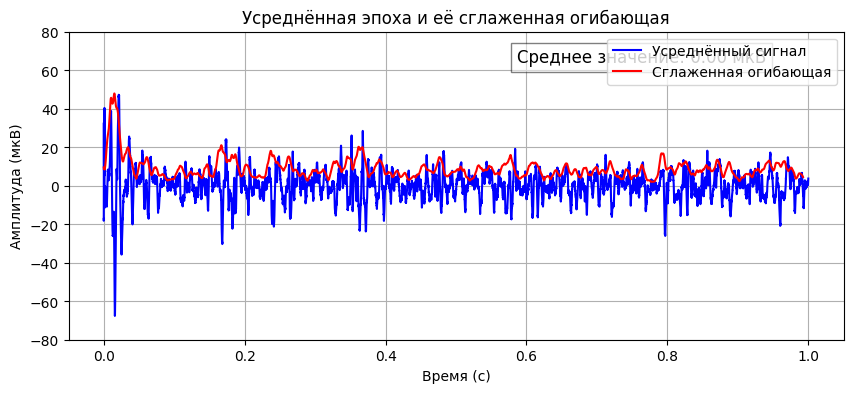

In [248]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Функция для вычисления скользящего среднего
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Получаем данные для всех оставшихся проб
all_data = []
for i in valid_epochs_indices:
    data = epochs[i].get_data(picks=[0]).flatten()  # Получаем данные первого канала и приводим к одной размерности
    all_data.append(data)

# Усредняем оставшиеся эпохи
mean_data = np.mean(all_data, axis=0)  # Усредняем по оставшимся пробам

# Находим огибающую с помощью преобразования Гильберта
analytic_signal = hilbert(mean_data)
amplitude_envelope = np.abs(analytic_signal)  # Огибающая сигнала

# Применяем сглаживание огибающей с помощью скользящего среднего
window_size = 300  # Размер окна для сглаживания (чем больше значение, тем сильнее сглаживание)
smoothed_envelope = moving_average(amplitude_envelope, window_size)

# Создаем временные метки
times = np.linspace(0, len(mean_data) / epochs.info['sfreq'], num=len(mean_data))
smoothed_times = times[:len(smoothed_envelope)]  # Изменяем длину временного интервала для сглаженной огибающей

# Отрисовка усредненной эпохи и сглаженной огибающей
plt.figure(figsize=(10, 4))  # Устанавливаем размер графика
plt.plot(times, mean_data * 1e6, label='Усреднённый сигнал', color='blue')  # Рисуем данные в мкВ
plt.plot(smoothed_times, smoothed_envelope * 1e6, label='Сглаженная огибающая', color='red')  # Рисуем сглаженную огибающую

plt.title('Усреднённая эпоха и её сглаженная огибающая')  # Заголовок
plt.ylim(-80, 80)  # Устанавливаем лимиты по оси Y

# Добавляем текст с средним значением амплитуды
mean_amplitude = np.mean(mean_data) * 1e6  # Среднее значение амплитуды в мкВ
plt.text(0.9, 0.9, f'Среднее значение: {mean_amplitude:.2f} мкВ',
         transform=plt.gca().transAxes, fontsize=12, color='black',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'),
         ha='right')  # Выровнять текст по правому краю

plt.xlabel('Время (с)')  # Подпись оси X
plt.ylabel('Амплитуда (мкВ)')  # Подпись оси Y
plt.legend(loc='upper right')  # Добавляем легенду
plt.grid(True)  # Включаем сетку
plt.show()


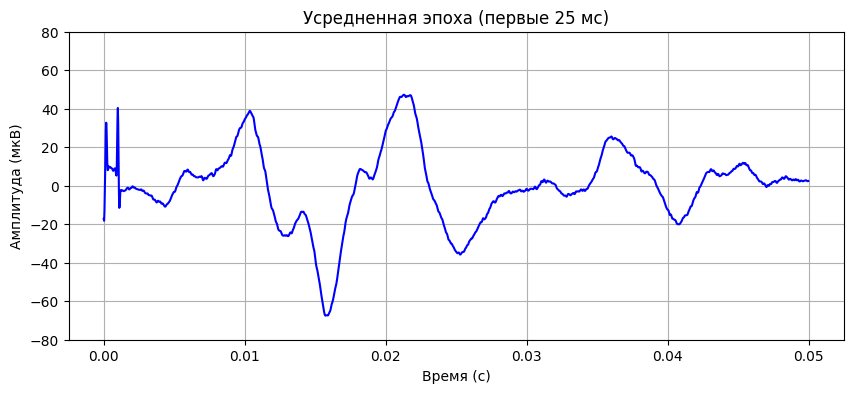

In [249]:
# Ограничиваем временные метки и данные до 60 мс
end_time_ms = 0.05 # 60 мс
end_sample = int(end_time_ms * epochs.info['sfreq'])  # Индекс, соответствующий 60 мс

# Отбираем только данные до 60 мс
mean_data_60ms = mean_data[:end_sample]
times_60ms = times[:end_sample]

# Отрисовка усредненной эпохи только за первые 60 мс
plt.figure(figsize=(10, 4))  # Устанавливаем размер графика
plt.plot(times_60ms, mean_data_60ms * 1e6, color='blue')  # Рисуем данные в мкВ
plt.title('Усредненная эпоха (первые 25 мс)')  # Заголовок
plt.ylim(-80, 80)  # Устанавливаем лимиты по оси Y

# Добавляем текст с средним значением амплитуды за первые 60 мс
mean_amplitude_60ms = np.mean(mean_data_60ms) * 1e6  # Среднее значение амплитуды в мкВ


plt.xlabel('Время (с)')  # Подпись оси X
plt.ylabel('Амплитуда (мкВ)')  # Подпись оси Y
plt.grid(True)  # Включаем сетку
plt.show()


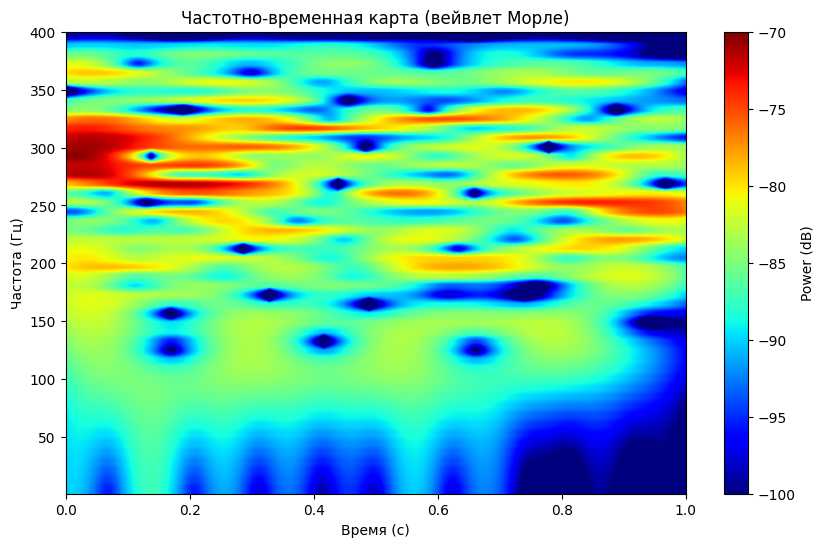

In [250]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_array_morlet

# Получаем данные для всех оставшихся проб
all_data = []
for i in valid_epochs_indices:
    data = epochs[i].get_data(picks=[0]).flatten()  # Получаем данные первого канала и приводим к одной размерности
    all_data.append(data)

# Усредняем оставшиеся эпохи
mean_data = np.mean(all_data, axis=0)  # Усредняем по оставшимся пробам

# Создаем временные метки
sfreq = epochs.info['sfreq']  # Частота дискретизации
times = np.linspace(0, len(mean_data) / sfreq, num=len(mean_data))

# Применяем вейвлет-преобразование
frequencies = np.logspace(np.log10(1), np.log10(400), num=50)  # Частоты от 1 до 40 Гц
n_cycles = frequencies / 2  # Число циклов для вейвлетов Морле (влияет на разрешение)
power = tfr_array_morlet(mean_data[None, None, :], sfreq=sfreq, freqs=frequencies,
                         n_cycles=n_cycles, output='power')

# Усреднение по каналам (в данном случае у нас один канал)
power = np.squeeze(power)  # Убираем лишние измерения

# Построение частотно-временной карты
plt.figure(figsize=(10, 6))
plt.imshow(10 * np.log10(power), extent=[times[0], times[-1], frequencies[0], frequencies[-1]],
           aspect='auto', origin='lower', cmap='jet', vmin=-100, vmax=-70)
plt.colorbar(label='Power (dB)')
plt.xlabel('Время (с)')
plt.ylabel('Частота (Гц)')
plt.title('Частотно-временная карта (вейвлет Морле)')
plt.show()
